# Importando bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Lendo dados

In [6]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [7]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [ ]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino, validação e teste mantendo a proporção das classes e com uma divisão de 20% para teste e 80% para treino e validação (onde se divide 25% do treino para validação)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Pre-processamento dos dados 

In [9]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [10]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [12]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [13]:
# Verificando a performance do modelo antes de otimização
y_val_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    345716
           1       0.20      0.19      0.20     11130

    accuracy                           0.95    356846
   macro avg       0.59      0.58      0.59    356846
weighted avg       0.95      0.95      0.95    356846



In [19]:
param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)


print("Melhores parâmetros:", grid.best_params_)
best_model = grid.best_estimator_

Melhores parâmetros: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}


In [20]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


## Criando matriz de confusão

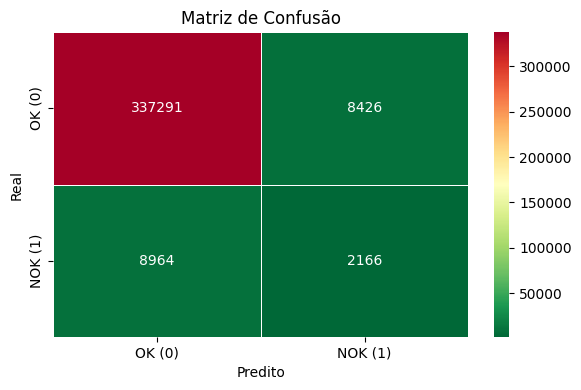

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [ ]:
# Acessar o pré-processador do pipeline
preprocessor = best_model.named_steps['preprocessor']

# Obter nomes das colunas numéricas
num_features = preprocessor.transformers_[0][2]

# Obter nomes das colunas categóricas codificadas
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

# Combinar tudo
all_features = np.concatenate([num_features, cat_features])


tree = best_model.named_steps['classifier']

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=all_features, class_names=['OK', 'NOK'])
plt.show()

In [ ]:
## Avaliando métricas

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df.head(3)

In [ ]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")


# Importância das features

In [ ]:
model = pipeline.named_steps['classifier']

preprocessor = pipeline.named_steps['preprocessor']

def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)

    return feature_names

feature_names = get_feature_names(preprocessor)

coefficients = model.coef_[0]

feature_importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(14, 6))
feature_importance.head(15).plot(kind='bar')  
plt.title("Importância das Variáveis - Regressão Logística")
plt.ylabel("Coeficiente")
plt.tight_layout()
plt.show()